In [8]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [9]:
import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_durations(y1, y2, show_result=False):
    plt.figure(1)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.plot(y1, label='Reward')
    plt.plot(y2, label='ave')

    plt.legend()

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    

In [10]:
import os

# Set the environment variable to restrict GPU visibility
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # Replace with the GPU device IDs you want to use

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# A2C

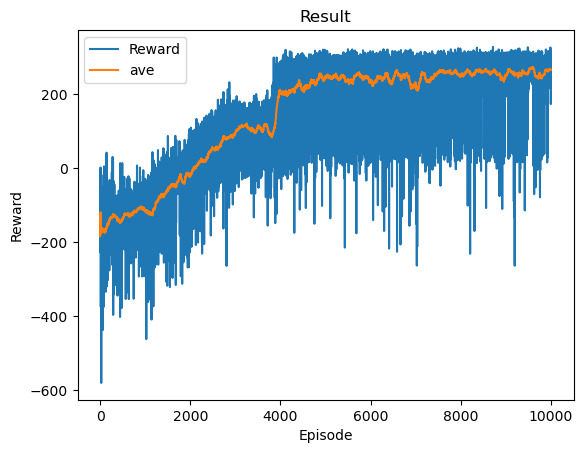

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
class ActorCritic(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(ActorCritic, self).__init__()
        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=-1)
        )
        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        # Return both the action probabilities and the state value
        return self.actor(state), self.critic(state)


num_episodes = 10000
lr = 0.001
gamma = 0.99
env_name = "LunarLander-v2"


env = gym.make(env_name)
input_size = env.observation_space.shape[0]
num_actions = env.action_space.n

model = ActorCritic(input_size, hidden_size=64, num_actions=num_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

ep_rewards = []
ep_rewards_ave = []

for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []

    while True:
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action_probs, value = model(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)
        log_probs.append(log_prob)
        values.append(value)

        next_state, reward, done, _ = env.step(action.item())
        rewards.append(reward)

        if done:
            break
        state = next_state

    # Calculate returns and advantages
    returns = []
    advantages = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    values = torch.cat(values)
    advantages = returns - values

    # Actor loss
    actor_loss = -torch.stack(log_probs) * advantages.detach()
    actor_loss = actor_loss.sum()

    # Critic loss
    critic_loss = nn.MSELoss()(values, returns)

    # Total loss
    loss = actor_loss + critic_loss

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the total reward for the episode
    # print(f"Episode {episode + 1}, Total Reward: {sum(rewards)}")

    ep_rewards.append(sum(rewards))
    ep_rewards_ave.append(np.mean(ep_rewards[-100:]))
    plot_durations(ep_rewards, ep_rewards_ave)

env.close()
plot_durations(ep_rewards, ep_rewards_ave, show_result=True)


torch.save(model.state_dict(), 'lunarlander_A2C')

In [14]:
env = gym.make("LunarLander-v2")

model_test = ActorCritic(input_size, hidden_size=64, num_actions=num_actions).to(device)
model_test.load_state_dict(torch.load("lunarlander_A2C"))
model_test.eval()

for episode in range(5):
    state = env.reset()

    while True:
        env.render()

        state = torch.FloatTensor(state)
        action_probs, value = model_test(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)

        next_state, reward, done, _ = env.step(action.item())

        if done:
            break
        state = next_state

env.close()

# REINFORCE

In [15]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_obs, n_actions, hidden_size):
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(n_obs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [16]:
def optimize(optimizer, rewards, log_probs):
    disc_ret = []
    ret = 0
    for reward in rewards[::-1]:
        ret = reward + GAMMA*ret
        disc_ret.insert(0, ret)


    disc_ret = torch.tensor(disc_ret)
    disc_ret = (disc_ret - torch.mean(disc_ret)) / (torch.std(disc_ret) + 1e-9)

    loss = 0
    for log_prob, ret in zip(log_probs, disc_ret):
        loss += -log_prob * ret

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [5]:
LR = 1e-4
GAMMA = 0.99

MAX_EP_NUM = 10000

env = gym.make("LunarLander-v2")
env.seed(0)

n_obs, n_actions = env.observation_space.shape[0], env.action_space.n

policy = PolicyNetwork(n_obs, n_actions, 64)
optimizer = optim.Adam(policy.parameters(), lr=LR)

In [6]:
def train():
    for ep in range(MAX_EP_NUM):
        state = env.reset()

        rewards = []
        log_probs = []

        while True:
            state = torch.Tensor(state).unsqueeze(0)

            probs = policy(state).squeeze(0)

            action = np.random.choice(n_actions, p=probs.detach().numpy())

            log_prob = torch.log(probs[action])

            next_state, reward, done, _ = env.step(action)

            state = next_state

            # reward = reward / 100

            rewards.append(reward)
            log_probs.append(log_prob)

            if done:
                break

        optimize(optimizer, rewards, log_probs)

        ep_rewards.append(sum(rewards))
        ep_rewards_ave.append(np.mean(ep_rewards[-100:]))
        plot_durations(ep_rewards, ep_rewards_ave)

    plot_durations(ep_rewards, ep_rewards_ave, show_result=True)

    env.close()

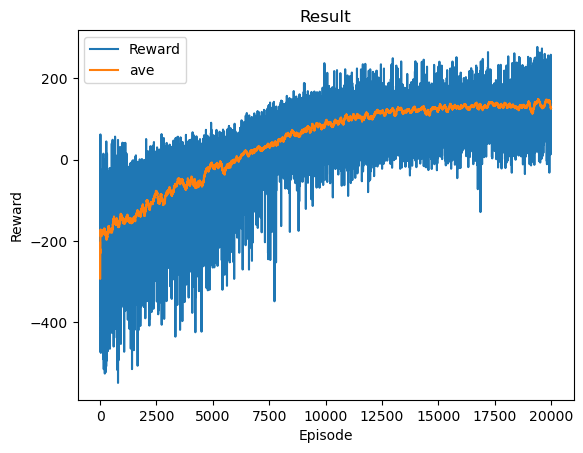

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
ep_rewards = []
ep_rewards_ave = []

train()

# MISTAKE! disc_return insertion not reversed

for reward in rewards[::-1]:
    ret = reward + GAMMA*ret
    # disc_ret.append(ret)
    disc_ret.insert(0, ret)

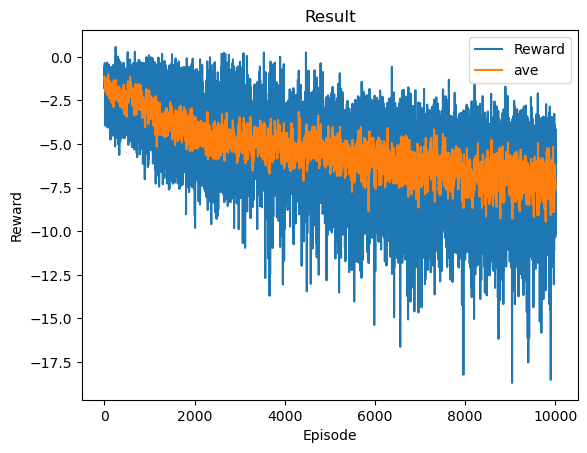

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
# discounted returns normalized, reward / 100, 10 000 episodes

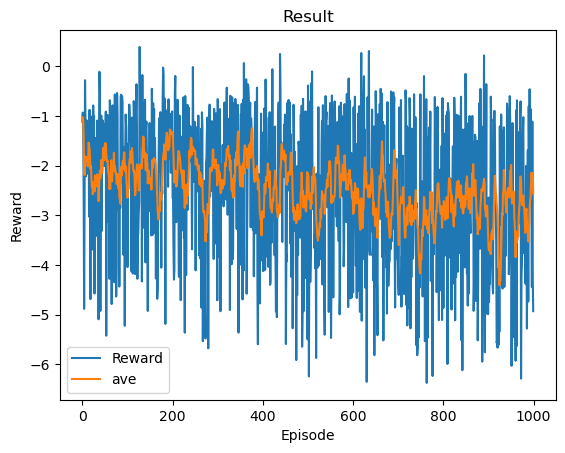

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
# discounted returns normalized, reward / 100
plot_durations(ep_rewards, ep_rewards_ave, show_result=True)

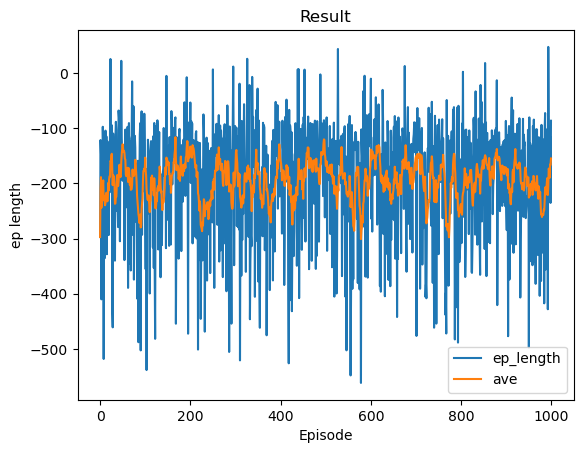

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [38]:
# discounted returns normalized
plot_durations(ep_rewards, ep_rewards_ave, show_result=True)

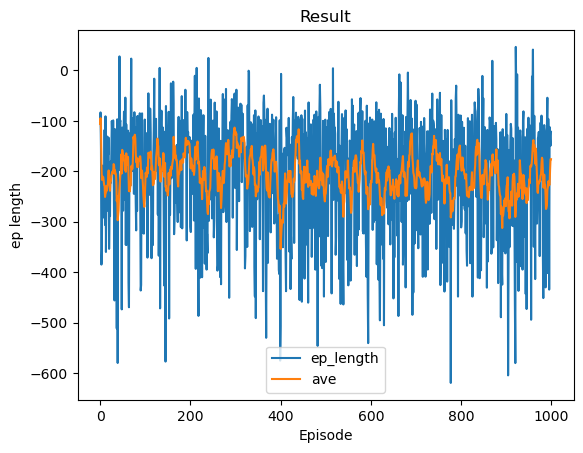

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
# discounted returns not normalized
plot_durations(ep_rewards, ep_rewards_ave, show_result=True)

# Example

In [ ]:
# https://github.com/kvsnoufal/reinforce/blob/main/train_lunarLander.py

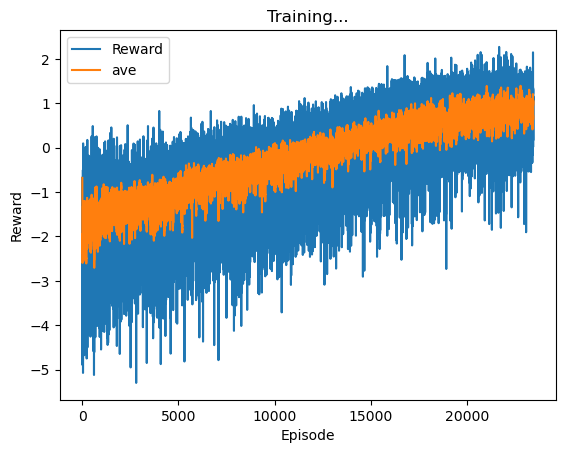

<Figure size 640x480 with 0 Axes>

In [3]:
import gym
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
# os.makedirs("outputs",exist_ok=True)

DEVICE="cuda:4"
ACTION_SPACE = [0,1,2,3]
EPISODES = 100000
STEPS = 1000
GAMMA=0.99
RENDER=False

class ReinforceModel(nn.Module):
    def __init__(self,num_action,num_input):
        super(ReinforceModel,self).__init__()
        self.num_action = num_action
        self.num_input = num_input

        self.layer1 = nn.Linear(num_input,64)
        self.layer2 = nn.Linear(64,num_action)
        
    def forward(self,x):
        x = torch.tensor(x,dtype=torch.float32,device=DEVICE).unsqueeze(0)
        x = F.relu(self.layer1(x))
        actions = F.softmax(self.layer2(x), dim=1)

        action = self.get_action(actions)
        log_prob_action = torch.log(actions.squeeze(0))[action]
        return action,log_prob_action
    def get_action(self,a):
        return np.random.choice(ACTION_SPACE,p=a.squeeze(0).detach().cpu().numpy())
    

env = gym.make("LunarLander-v2")
print(env.action_space,env.observation_space)

model = ReinforceModel(4,8).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
all_rewards = []
all_rewards_ave = []
best_rolling = -99999
for episode in range(EPISODES):
    done=False
    state = env.reset()
    lp=[]
    a=[]
    r=[]
    d=[]
    s=[]
    for step in range(STEPS):
        if RENDER:
            env.render()
        action,log_prob = model(state)
        state,r_,done,i_ = env.step(action)
        lp.append(log_prob)
        r_ = r_ /100
        r.append(r_)
        if done:
            all_rewards.append(np.sum(r))
            all_rewards_ave.append(np.mean(all_rewards[-10:]))
            
            if episode%100 ==0:
                print(f"EPISODE {episode} SCORE: {np.sum(r)} roll{pd.Series(all_rewards).tail(100).mean()}")
                # RENDER = True
                # torch.save(model.state_dict(), 'outputs/last_params_cloud.ckpt')
                # if pd.Series(all_rewards).tail(100).mean()>best_rolling:
                #     best_rolling = pd.Series(all_rewards).tail(100).mean()
                #     print("saving...")
                #     torch.save(model.state_dict(), 'outputs/best_params_cloud.ckpt')
            break
 

    discounted_rewards = []

    for t in range(len(r)):
        Gt = 0 
        pw = 0
        for r_ in r[t:]:
            Gt = Gt + GAMMA**pw * r_
            pw = pw + 1
        discounted_rewards.append(Gt)
    
    discounted_rewards = np.array(discounted_rewards)

    discounted_rewards = torch.tensor(discounted_rewards,dtype=torch.float32,device=DEVICE)
    discounted_rewards = (discounted_rewards - torch.mean(discounted_rewards))/ (torch.std(discounted_rewards))
    log_prob = torch.stack(lp)
    policy_gradient = -log_prob*discounted_rewards

    model.zero_grad()
    policy_gradient.sum().backward()
    optimizer.step()

    plot_durations(all_rewards, all_rewards_ave)


plot_durations(all_rewards, all_rewards_ave, show_result=True)
